<a href="https://colab.research.google.com/github/miguel-fc/PyTorch-tools/blob/main/nr_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Python related required packages
import io
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
# matplotlib.use('agg')
# plt.ioff()
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm

In [2]:
#Downloand numpy arrays for neutron reflectivity curves and parameters used to generate 
#them
!gdown "https://drive.google.com/uc?id=1--SS7PoObNsKwwN8Hg__ZBRvPCqqEBpA"
!gdown "https://drive.google.com/uc?id=1SmWTmLlvg-cEyzXIlt8ik286pQ4nE86G"

Downloading...
From: https://drive.google.com/uc?id=1--SS7PoObNsKwwN8Hg__ZBRvPCqqEBpA
To: /content/sld_fp34.npy
100% 1.61M/1.61M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SmWTmLlvg-cEyzXIlt8ik286pQ4nE86G
To: /content/params_fp34.npy
100% 25.3k/25.3k [00:00<00:00, 27.7MB/s]


In [3]:
#Stored those numpy arrays
sld_arr = np.load('sld_fp34.npy')
params_arr = np.load('params_fp34.npy')

In [4]:
#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
# import torch.utils.data as data_utils
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
def split_input_arrays(in_data,label_data,size_split):

    xtr, xjunk, ytr, yjunk = train_test_split(in_data,label_data,train_size=size_split)
    xv, xte, yv, yte = train_test_split(xjunk,yjunk, test_size=0.5)
    print('xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape')
    print(xtr.shape, ytr.shape, xv.shape, yv.shape, xte.shape, yte.shape)
    return xtr, ytr, xv, yv, xte, yte

In [6]:
#Create dataset and dataloaders from splitted arrays
def get_dataloaders_fromsplitarrays(xtr,ytr,xv,yv,xte,yte,batch_size):

    tr_set = torch.utils.data.TensorDataset(torch.from_numpy(xtr).float(), torch.from_numpy(ytr).float())
    tr_load = torch.utils.data.DataLoader(tr_set, batch_size=batch_size, shuffle=True)

    va_set = torch.utils.data.TensorDataset(torch.from_numpy(xv).float(), torch.from_numpy(yv).float())
    va_load = torch.utils.data.DataLoader(va_set, batch_size=batch_size, shuffle=True)

    te_set = torch.utils.data.TensorDataset(torch.from_numpy(xte).float(), torch.from_numpy(yte).float())
    te_load = torch.utils.data.DataLoader(te_set, batch_size=batch_size, shuffle=True)

    return tr_set, va_set, te_set, tr_load, va_load, te_load 

In [7]:
xtrain, ytrain, xval, yval, xtest, ytest = \
split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(629, 2, 128) (629, 4) (79, 2, 128) (79, 4) (79, 2, 128) (79, 4)


In [8]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,yval,batch_size=50)

In [9]:
class Encoder(nn.Module):
    
    def __init__(self,encoded_space_dim,dim1,dim2):
        super().__init__()

        self.encoder = nn.Sequential(
        nn.Linear(dim1 * dim2, 500),
        nn.ReLU(True),
        nn.Linear(500, 500),
        nn.ReLU(True),
        nn.Linear(500,encoded_space_dim))
        
    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self,encoded_space_dim,dim1,dim2):
        super().__init__()

        self.decoder = nn.Sequential(
        nn.Linear(encoded_space_dim, 500),
        nn.ReLU(True),
        nn.Linear(500, 500),
        nn.ReLU(True),
        nn.Linear(500, dim1 * dim2))
        
    def forward(self, x):
        x = self.decoder(x)
        return x

In [10]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
torch.manual_seed(0)

#Dimension of the latent space and of the graphs
d = 2
in_d1 = 2
in_d2 = 128


encoder = Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2)
decoder = Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [11]:
#Move encoder to device
encoder.to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [12]:
#Move decoder to device
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=256, bias=True)
  )
)

In [13]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for data,label in dataloader: 
        img = data
        img = img.view(img.size(0), -1).to(device)  
        label = label.to(device)
        latent = encoder(img)
        decoded_img = decoder(latent)
        loss = loss_fn(decoded_img, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [14]:
### Valid function
def valid_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.view(img.size(0), -1).to(device) 
            label = label.to(device)
            latent = encoder(img)
            decoded_img = decoder(latent)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(img.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [15]:
def plot_ae_outputs(encoder,decoder,dataset,device,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(10):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      #Notice that below i'm loading an image only, so it needs to be flatten
      #before entering the network
      img = torch.flatten(img).to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
        decoded_img = decoder(encoder(img))
      plt.plot(img.cpu().reshape(2,128).numpy()[0],img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu().reshape(2,128).numpy()[0],decoded_img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

In [16]:
num_epochs = 250
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = valid_epoch(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/250 	 train loss 0.11885976046323776 	 val loss 0.015707187354564667
EPOCH 2/250 	 train loss 0.008000077679753304 	 val loss 0.0043563093058764935
EPOCH 3/250 	 train loss 0.0025871603284031153 	 val loss 0.0023358697071671486
EPOCH 4/250 	 train loss 0.001724977046251297 	 val loss 0.0021186796948313713
EPOCH 5/250 	 train loss 0.0016384465852752328 	 val loss 0.0020893968176096678
EPOCH 6/250 	 train loss 0.0016537281917408109 	 val loss 0.002129679312929511
EPOCH 7/250 	 train loss 0.0016216820804402232 	 val loss 0.002108175540342927
EPOCH 8/250 	 train loss 0.0016454638680443168 	 val loss 0.002098013646900654
EPOCH 9/250 	 train loss 0.0016186983557417989 	 val loss 0.0021060979925096035
EPOCH 10/250 	 train loss 0.0016334535321220756 	 val loss 0.002097807126119733
EPOCH 11/250 	 train loss 0.0016450887778773904 	 val loss 0.0020906294230371714
EPOCH 12/250 	 train loss 0.0016382028115913272 	 val loss 0.0020757028833031654
EPOCH 13/250 	 train loss 0.001625762088224291

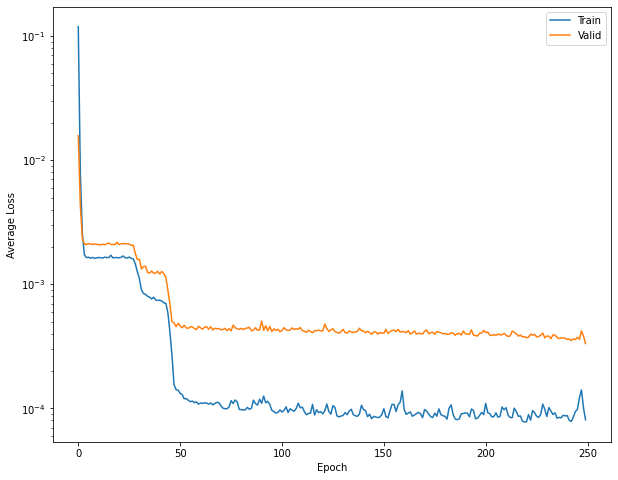

In [17]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

For image 0, the loss = 0.00010660983389243484
For image 1, the loss = 8.393183088628575e-05
For image 2, the loss = 6.314295751508325e-05
For image 3, the loss = 1.7124562873505056e-05
For image 4, the loss = 2.0763194697792642e-05
For image 5, the loss = 2.411625064269174e-05
For image 6, the loss = 0.00010938635386992246
For image 7, the loss = 0.011219018138945103
For image 8, the loss = 0.0003578592441044748
For image 9, the loss = 1.1506859664223157e-05


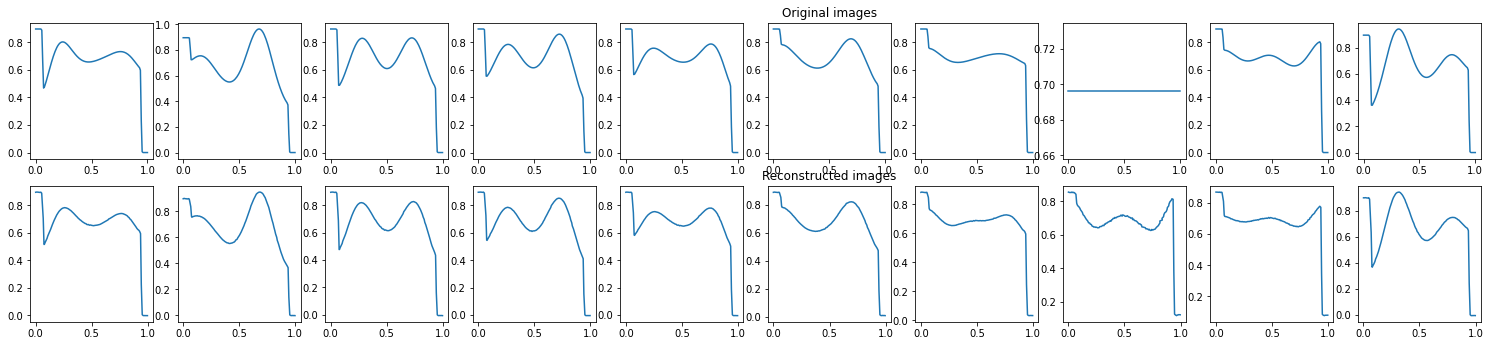

In [18]:
#Seeing how the model performs for the test unseen data. For this we choose 10 figures
#running through model.eval() and compute the loss plus we look at them visually

#Similar to plot_ae_outputs, except that this is one used to see the loss for 
#data in the test_loader. It also prints the loss for each
def plot_test_outputs(encoder,decoder,dataset,device,n=10):
    plt.figure(figsize=(26,5.5))
    for i in range(10):
      ax = plt.subplot(2,n,i+1)
      img,_ = dataset[i]
      #Notice that below i'm loading an image only, so it needs to be flatten
      #before entering the network
      img = torch.flatten(img).to(device)
      encoder.eval().to(device)
      decoder.eval().to(device)
      with torch.no_grad():
         decoded_img  = decoder(encoder(img))
         loss = loss_fn(decoded_img,img)
         print('For image {}, the loss = {}'.format(i,loss.data))
      plt.plot(img.cpu().reshape(2,128).numpy()[0],img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.plot(decoded_img.cpu().reshape(2,128).numpy()[0],decoded_img.cpu().reshape(2,128).numpy()[1]) 
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


plot_test_outputs(encoder,decoder,test_dataset,device,n=10)

In [19]:
#Running the autoencoder on the train data. The goal here is to obtain the
#latent variables so they can be plot and also for training a MLP

def get_latent_variables(encoder, decoder, device, dataloader):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): 
        # Define the lists to store the original images, the recreated ones,
        # the latent variables and the corresponding labels
        list_img = []
        list_decoded_img = []
        list_latent = []
        list_labels = []

        for  data, label in dataloader:
            img = data
            img = img.view(img.size(0), -1).to(device) 
            # Encode and Decode data
            latent = encoder(img)
            decoded_img = decoder(latent)
            # Append the network output and the original image to the lists
            list_img.append(img.cpu())
            list_decoded_img.append(decoded_img.cpu())
            list_latent.append(latent.cpu())
            list_labels.append(label.cpu())
# Convert list into a torch.tensor
        t_img = torch.cat(list_img)
        t_decoded_img = torch.cat(list_decoded_img)
        t_latent = torch.cat(list_latent) 
        t_labels = torch.cat(list_labels)
    return t_img, t_decoded_img, t_latent, t_labels

In [20]:
#Creating dataloaders for the MLP. This includes train, valid and test
#Saving them on disk too

img, out_img, train_latent_var, train_labels_var = get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([629, 256]) torch.Size([629, 256]) torch.Size([629, 2]) torch.Size([629, 4])
torch.Size([79, 256]) torch.Size([79, 256]) torch.Size([79, 2]) torch.Size([79, 4])
torch.Size([79, 256]) torch.Size([79, 256]) torch.Size([79, 2]) torch.Size([79, 4])


tensor([-0.3917, -0.1676])
tensor([0.2917, 0.3315])


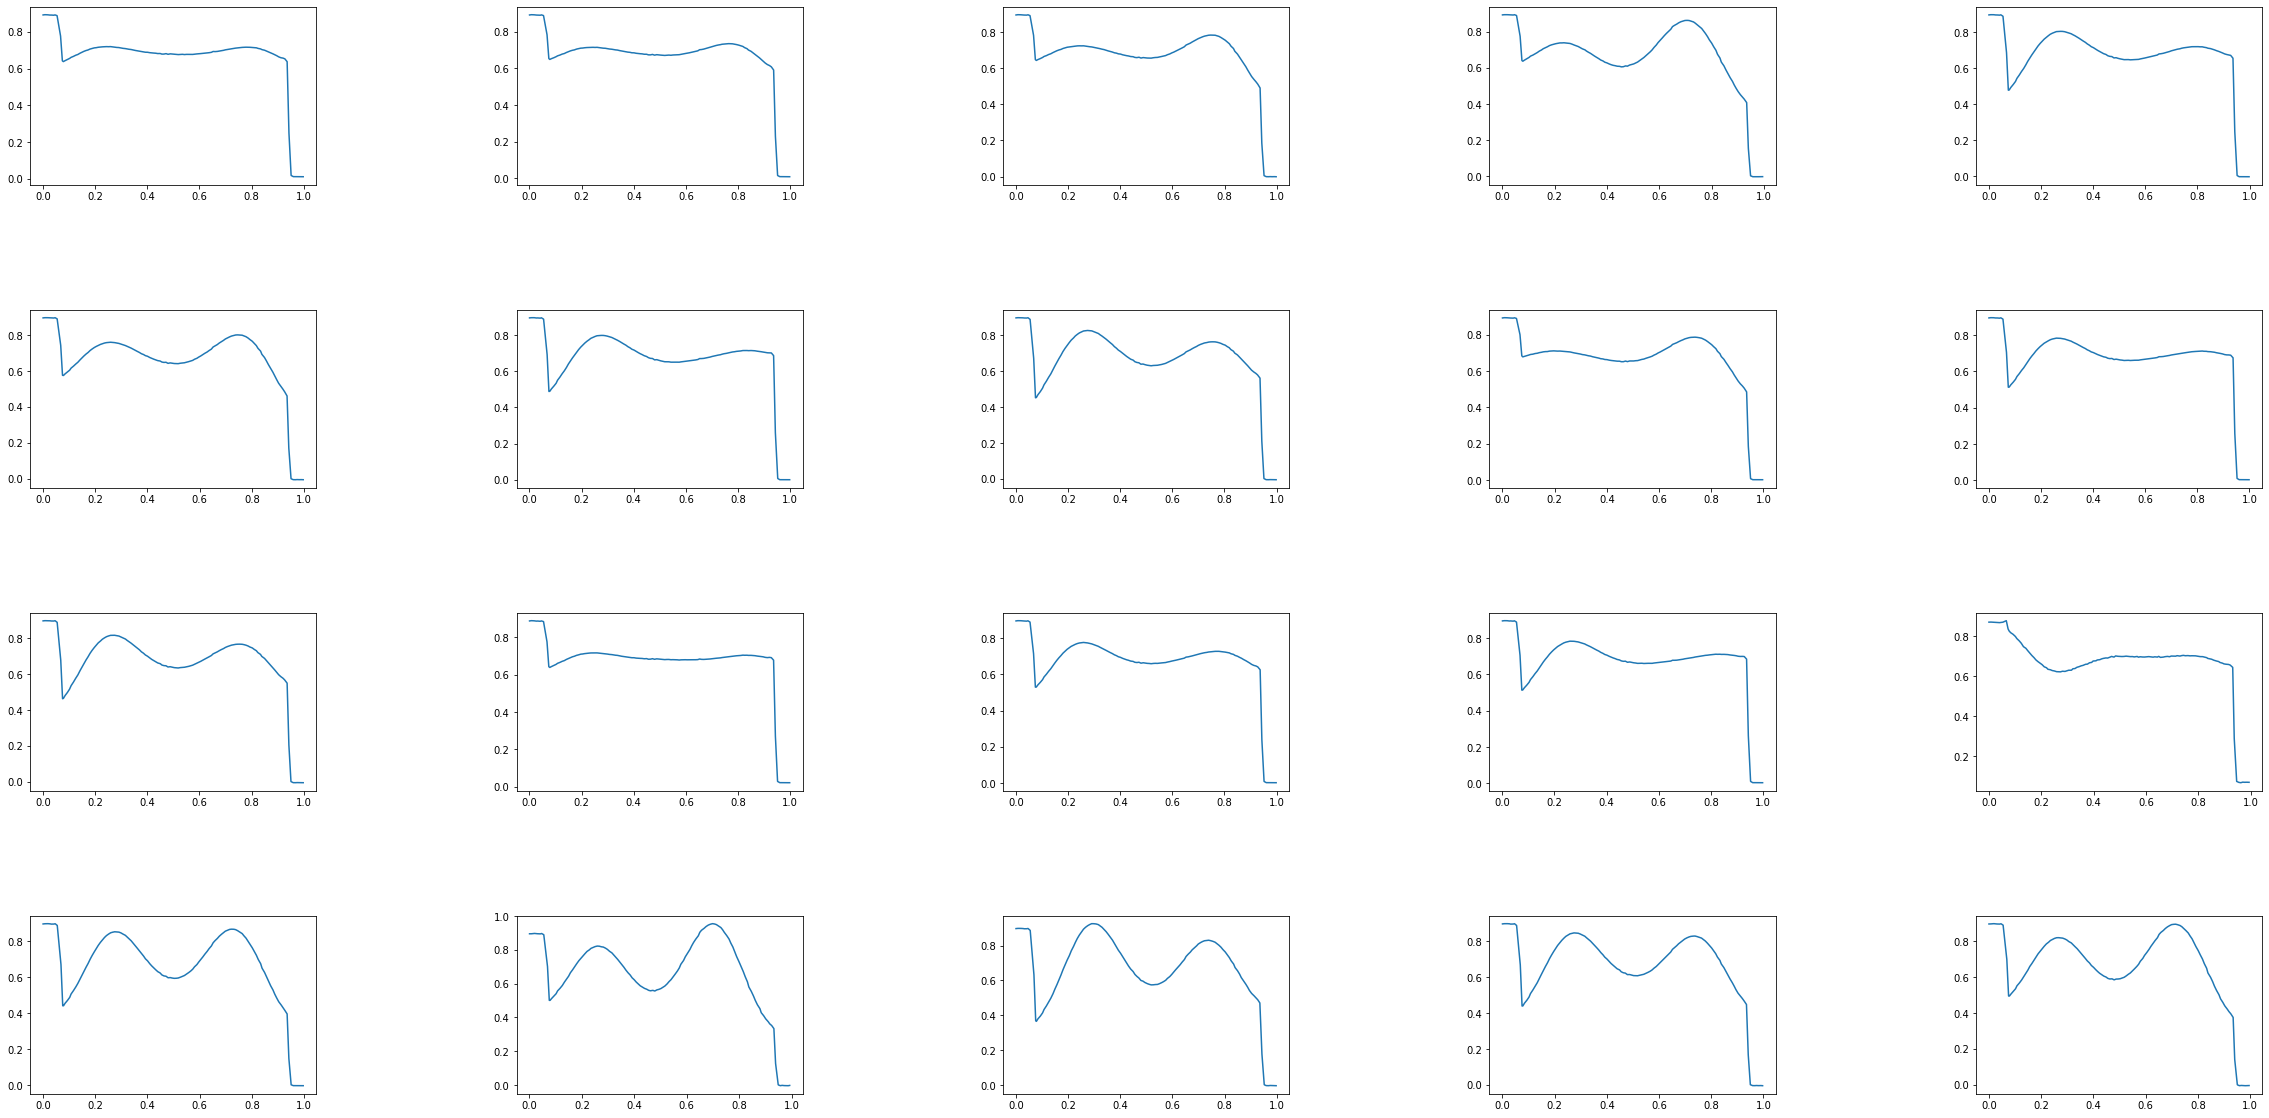

In [21]:
#Interpolating in the latent space

#I have to use gridspec because torch.vision.make_grid works only with images 
#and here we have graphs. Would need to convert those graphs into images.

#Update: plots have been now saved as figures and the manifold at the end 
#shows how this can be done. Using torch.vision.make_grid is trivial after that

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), 2,128).cpu()

rows = 4
cols = 5
n=20

fig = plt.figure(figsize=(40,20))
gs = gridspec.GridSpec(rows, cols, wspace = 0.7, hspace = 0.7)
for i in range(n):
    ax = fig.add_subplot(gs[i])
    ax.plot(img_recon[i][0],img_recon[i][1]);
    # ax.set_xticks([])
    # ax.set_yticks([])


In [22]:
img_recon.shape

torch.Size([200, 2, 128])

In [23]:
# for i in range(100):
#   plt.plot(img_recon[i][0],img_recon[i][1])
# plt.show()

In [24]:
img_recon[0].shape

torch.Size([2, 128])

In [25]:
encoded_samples = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label = sample[1]
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label0'] = label[0].numpy()
    encoded_sample['label1'] = label[1].numpy()
    encoded_sample['label2'] = label[2].numpy()
    encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 629/629 [00:00<00:00, 3535.04it/s]


,Enc. Variable 0,Enc. Variable 1,label0,label1,label2,label3
0,-0.648407,0.650846,0.11,-0.0512,-0.147,1.19177
1,0.007070,0.178649,0.111,-0.0836,-0.0254,1.72601
2,0.241411,-0.812437,0.28,-0.548,-0.0763,1.32695
3,-0.304409,0.046272,0.179,-0.151,-0.358,8.39772
4,-0.375595,-0.313883,0.219,-0.401,-0.314,2.30856
...,...,...,...,...,...,...
624,-0.265614,-0.167646,0.225,-0.384,-0.254,4.33182
625,-0.202661,-0.041059,0.107,-0.28,-0.187,5.60287
626,-0.053306,0.167045,0.155,-0.0877,-0.0308,2.66845
627,-0.299029,-0.102878,0.161,-0.249,-0.245,2.4068


In [26]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label0.astype(float), opacity=0.7)

In [27]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label1.astype(float), opacity=0.7)

In [28]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label2.astype(float), opacity=0.7)

In [29]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label3.astype(float), opacity=0.7)

In [30]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label0','label1','label2','label3'],axis=1))


fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label0.astype(float),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label1.astype(float),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label2.astype(float),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label3.astype(float),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



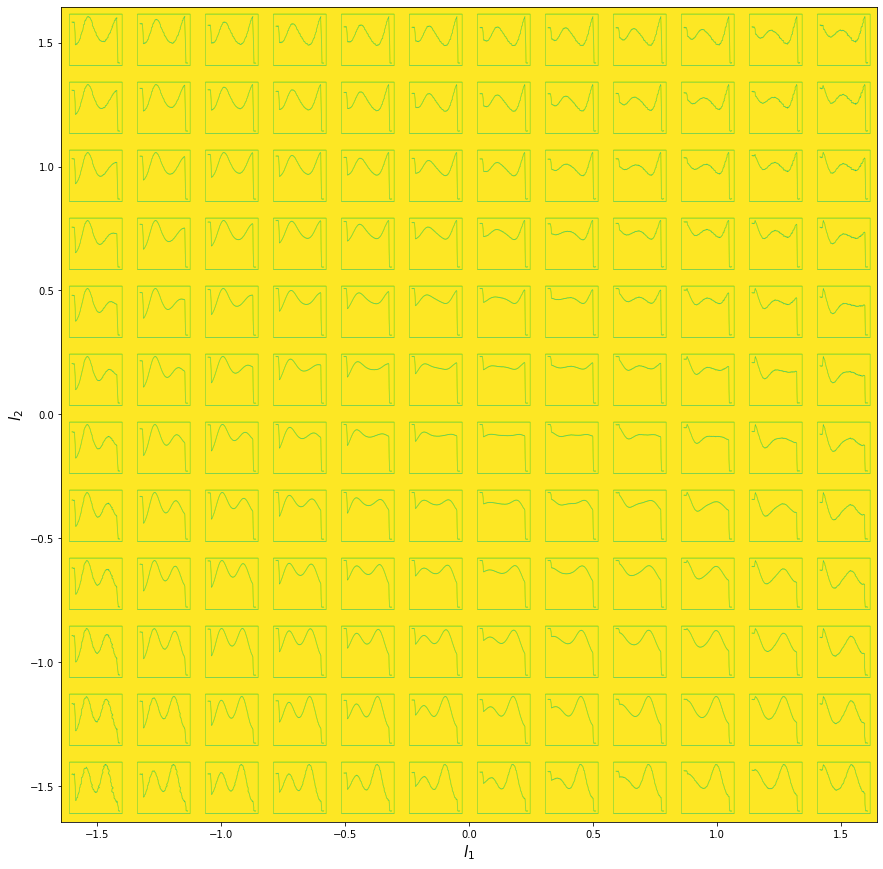

In [31]:
#The following two variables are hardwired because we cannot know their values 
#before the dpi is assigned (see dpi below)
simg_dim1 = 720
simg_dim2 = 1080

d_mani = 12

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

manifold = np.zeros((simg_dim1 * d_mani, simg_dim2 * d_mani))
grid_x = norm.ppf(np.linspace(0.95, 0.05, d_mani))
grid_y = norm.ppf(np.linspace(0.05, 0.95, d_mani))

for i, xi in enumerate(grid_x):
  for j, yi in enumerate(grid_y):
    z_sample = torch.from_numpy(np.array([[xi, yi]])).float().to(device)
    imdec = decoder(z_sample)
    imdec = imdec.view(imdec.size(0), 2,128).detach().cpu()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(imdec[0][0],imdec[0][1])
    n_img = get_img_from_fig(fig)

    manifold[i * simg_dim1: (i + 1) * simg_dim1,
           j * simg_dim2: (j + 1) * simg_dim2] = n_img


fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(manifold, cmap='viridis',
          extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])
ax.set_xlabel("$l_1$",fontsize=15);
ax.set_ylabel("$l_2$",fontsize=15);

In [32]:
#Saving data into gdrive

# from google.colab import drive
# drive.mount('/content/gdrive')

# torch.save(train_latent_var,'train_latent_var.pt')
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')

# !mv train_latent_var.pt /content/gdrive/MyDrive/neutron_reflectivity/
# !mv train_labels_var.pt /content/gdrive/MyDrive/neutron_reflectivity/
# !mv valid_latent_var.pt /content/gdrive/MyDrive/neutron_reflectivity/
# !mv valid_labels_var.pt /content/gdrive/MyDrive/neutron_reflectivity/
# !mv test_latent_var.pt /content/gdrive/MyDrive/neutron_reflectivity/
# !mv test_labels_var.pt /content/gdrive/MyDrive/neutron_reflectivity/

# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/